In [1]:
from torch import load
import numpy as np
import sys

sys.path.append('../..')

from hydroml.model import BaryonModel

import matplotlib.pyplot as plt

In [2]:
# If you haven't trained a model yet, please go to the file 'baryons_train.ipynb' first!
model = load('../../models/baryon_model_Ru_200gev.pt')
model.eval()

BaryonModel(
  (linear_in): Linear(in_features=41, out_features=256, bias=True)
  (linear_1): Linear(in_features=256, out_features=256, bias=True)
  (linear_2): Linear(in_features=256, out_features=80, bias=True)
  (leaky): LeakyReLU(negative_slope=0.01)
)

In [3]:
from hydroml.dataset import TrainDatasetRu
from torch.utils.data import DataLoader

import pickle

with open("DICTP.dat", "rb") as pf:
        DATAP = pickle.load(pf)

# Initial eta grid
etaInit = DATAP["INITIAL_eta"]
# Final eta grid
etaFinal = DATAP["FINAL_eta"]


arrayNetProtonInit = DATAP["0-40"]["INITIAL"][15000:] # 3
arrayNetProtonFinal = DATAP["0-40"]["FINAL"][15000:] # 4

dataset = TrainDatasetRu(arrayNetProtonInit, arrayNetProtonFinal, etaInit, etaFinal, 72, 141, 4)

data_loader = DataLoader(
    dataset=dataset,
    batch_size=1,
    shuffle=True,
)

print(len(data_loader))

4995


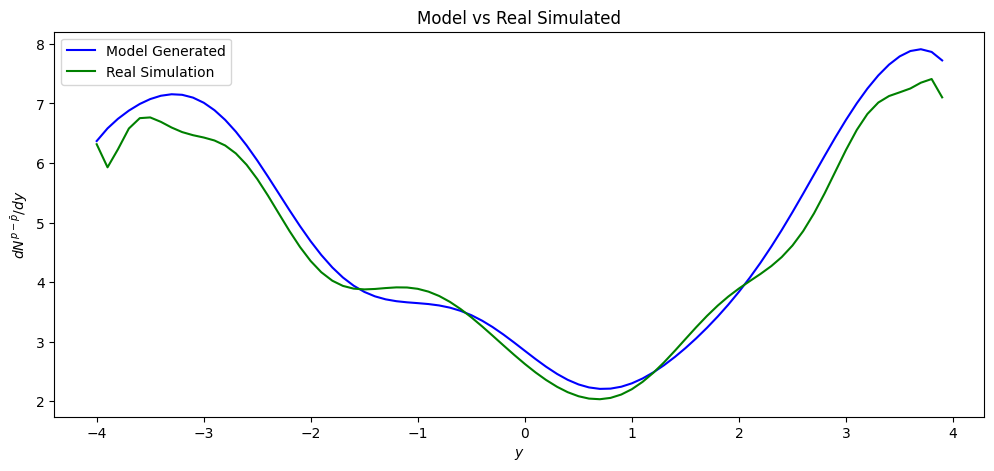

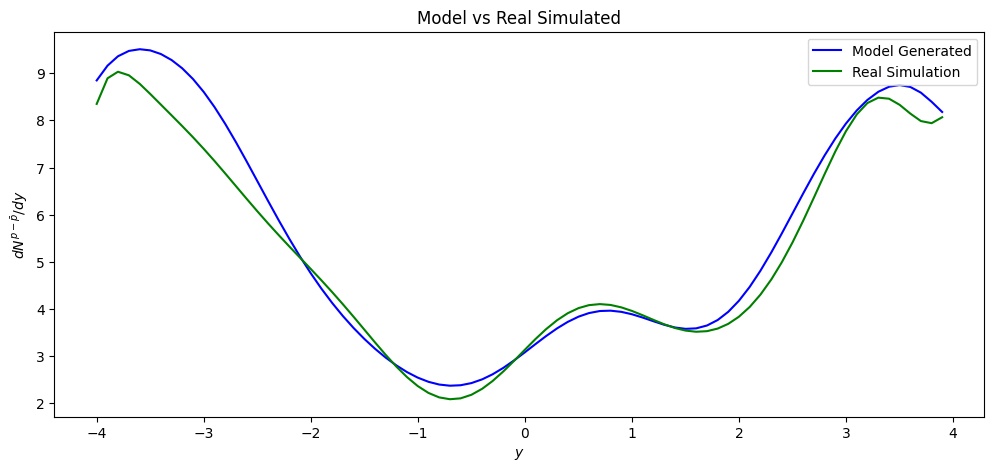

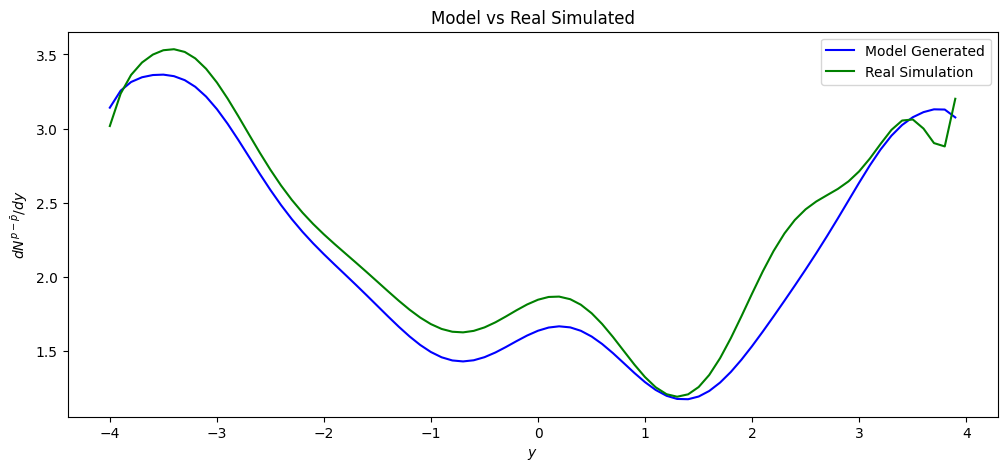

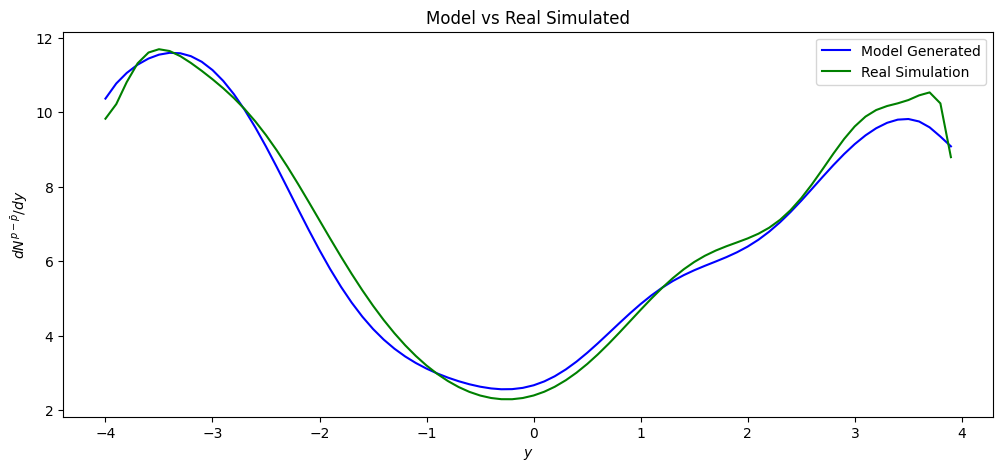

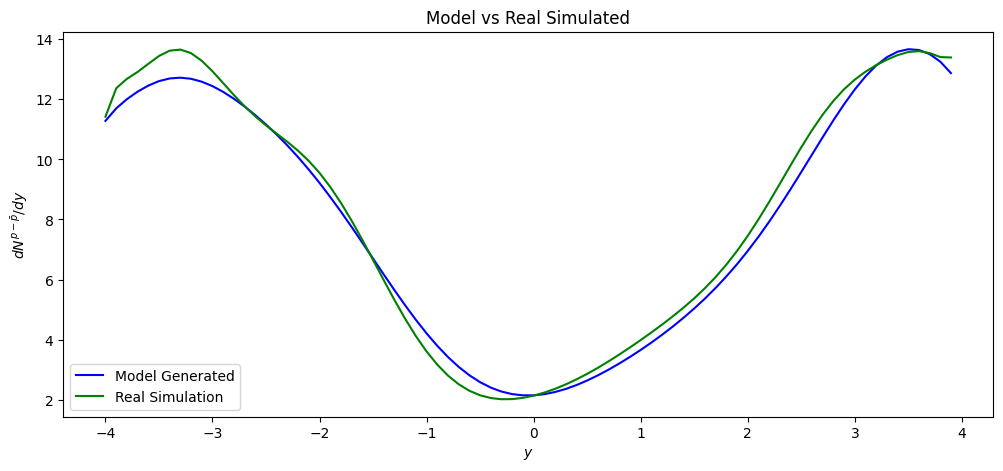

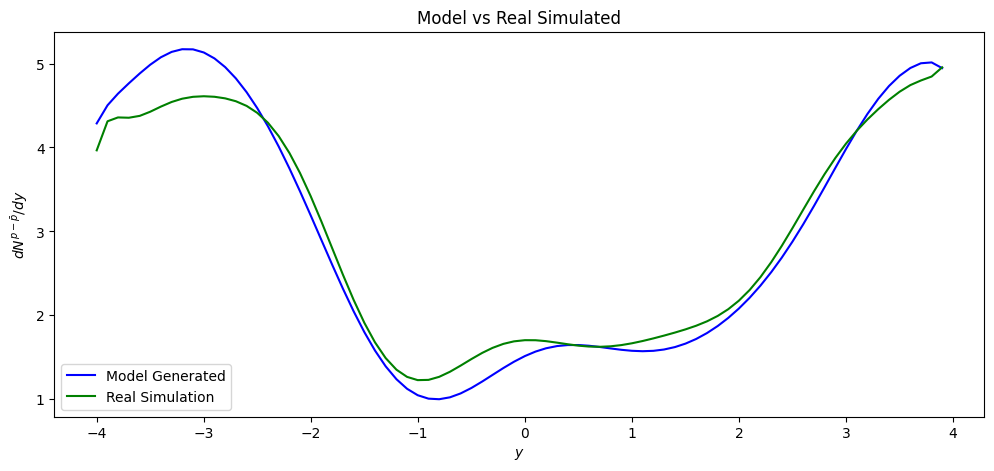

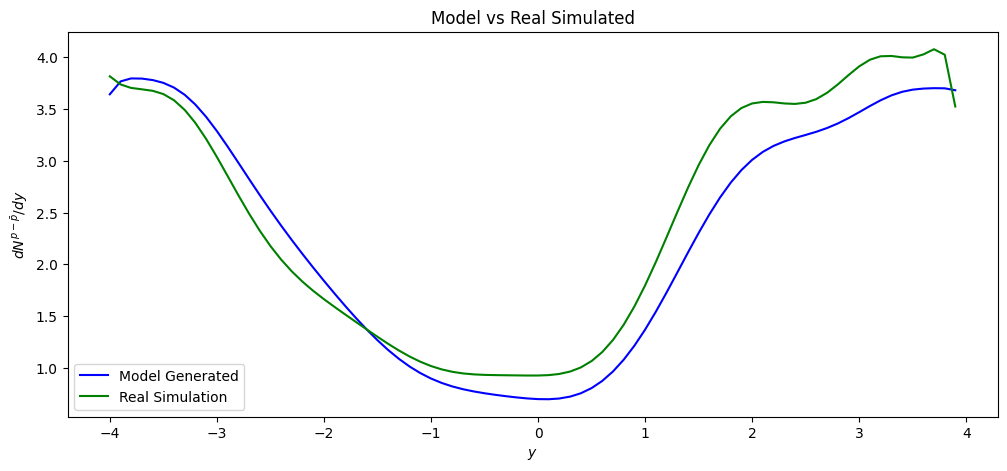

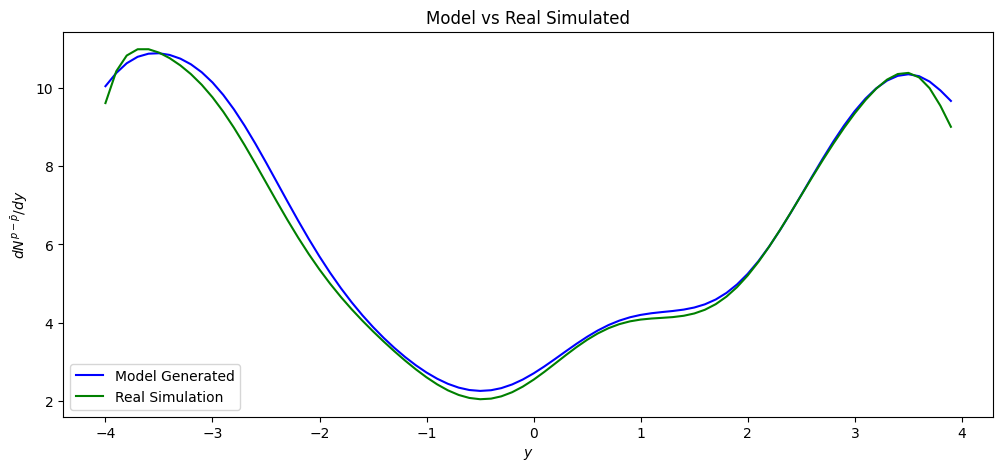

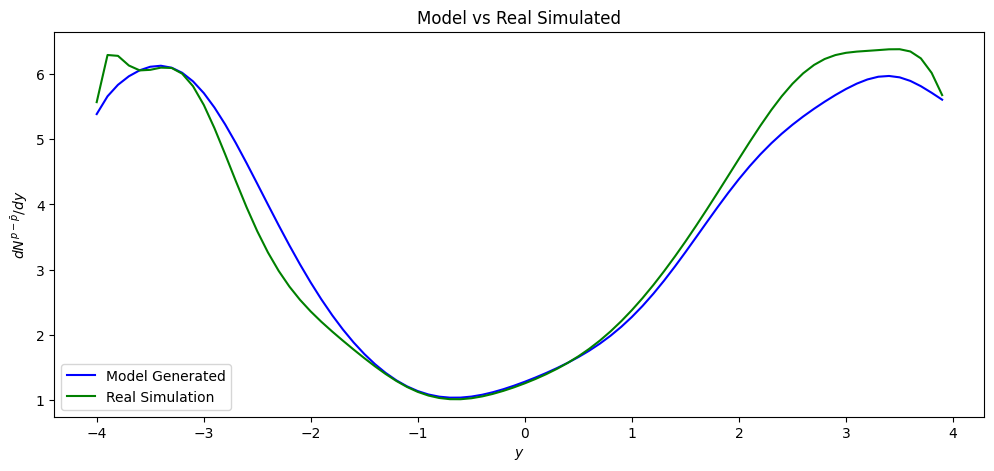

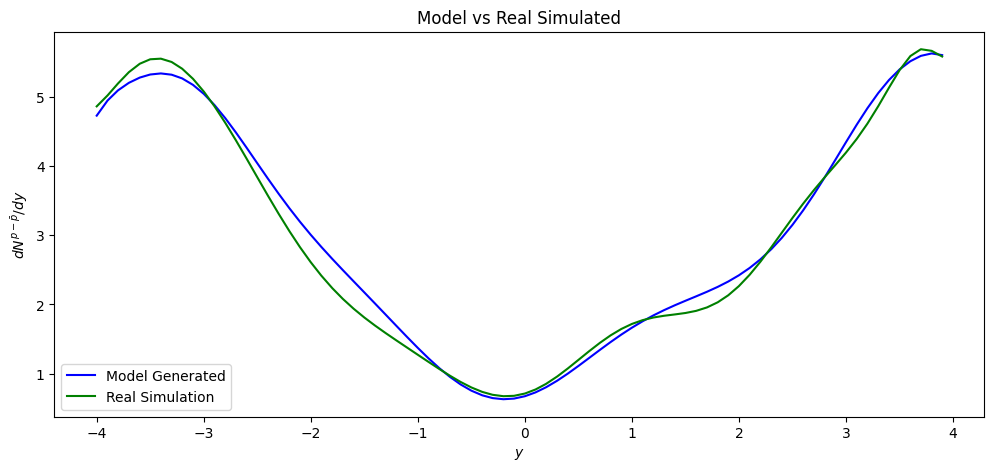

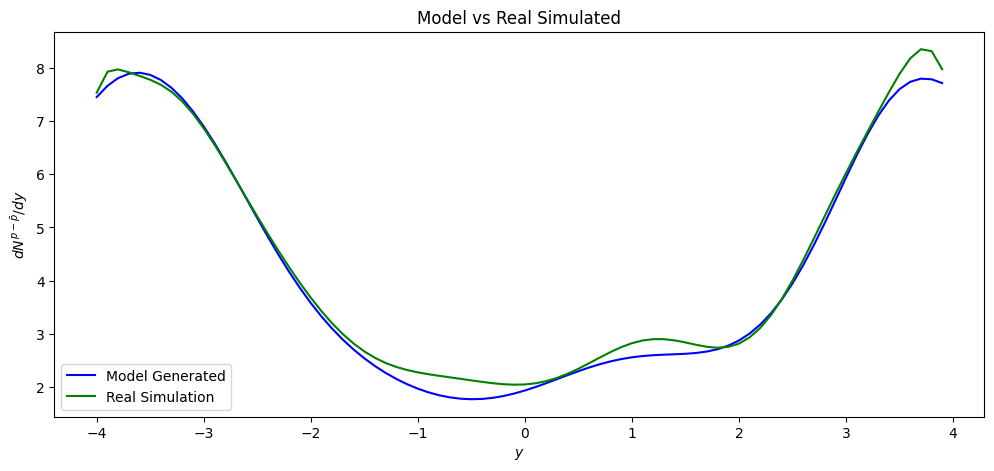

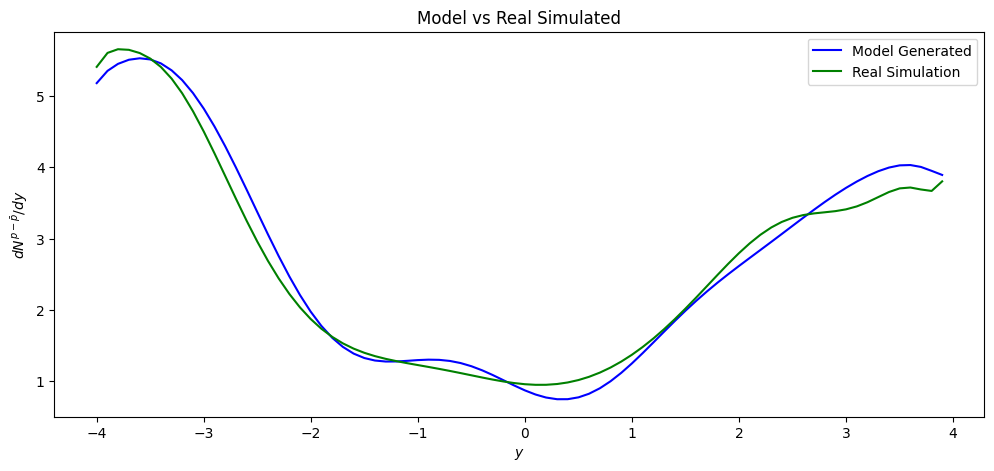

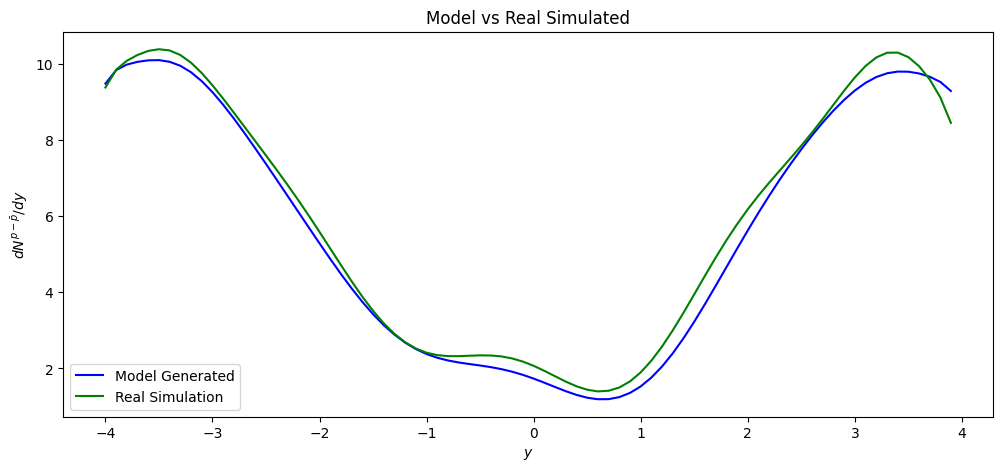

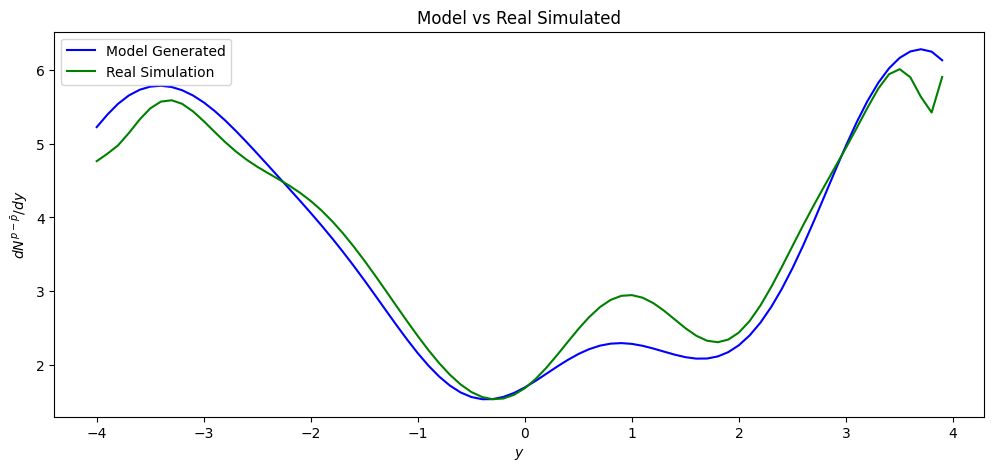

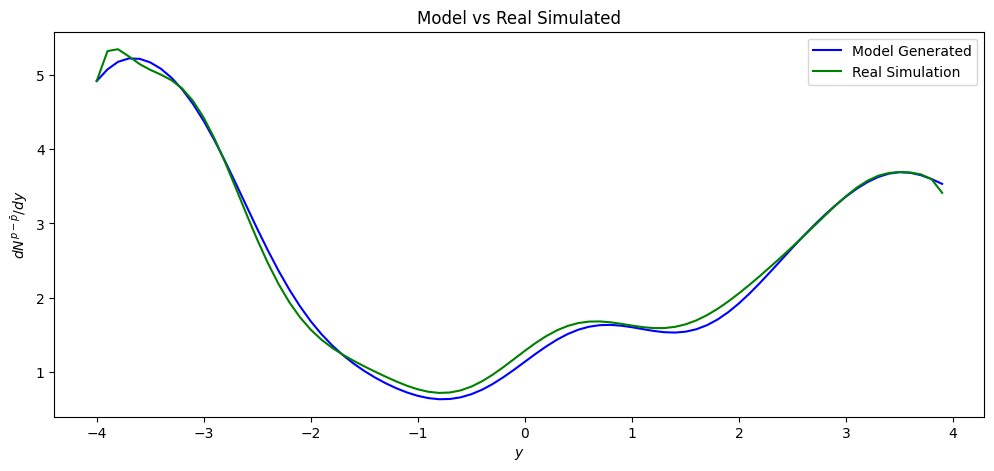

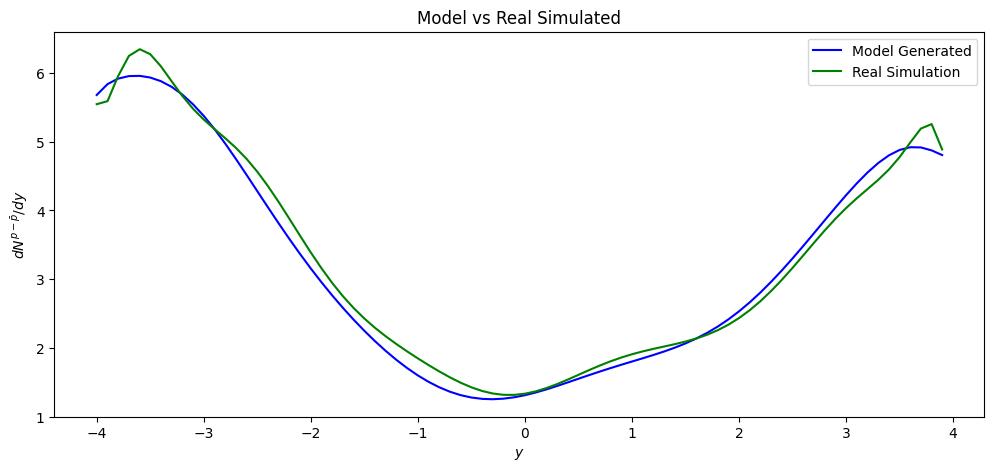

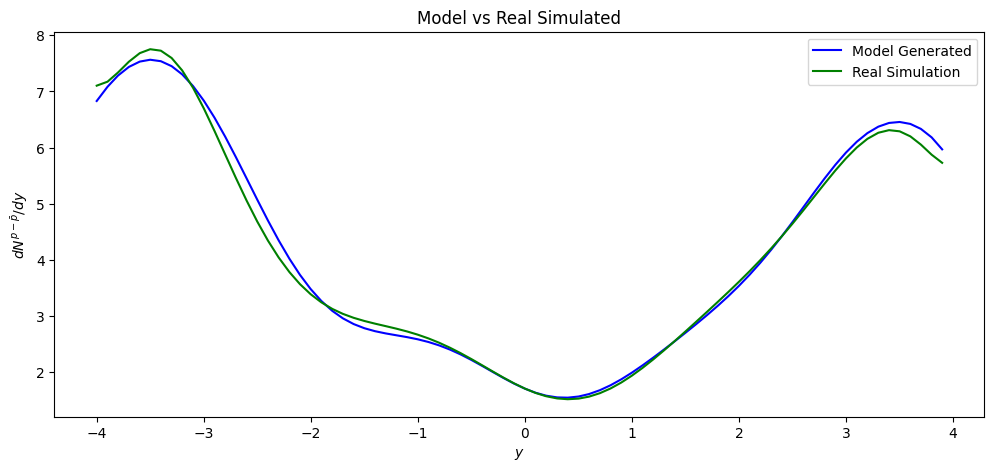

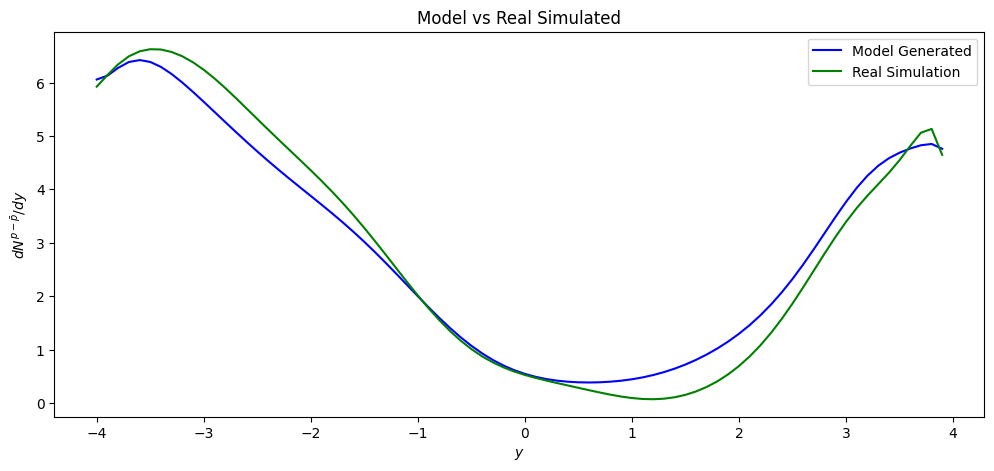

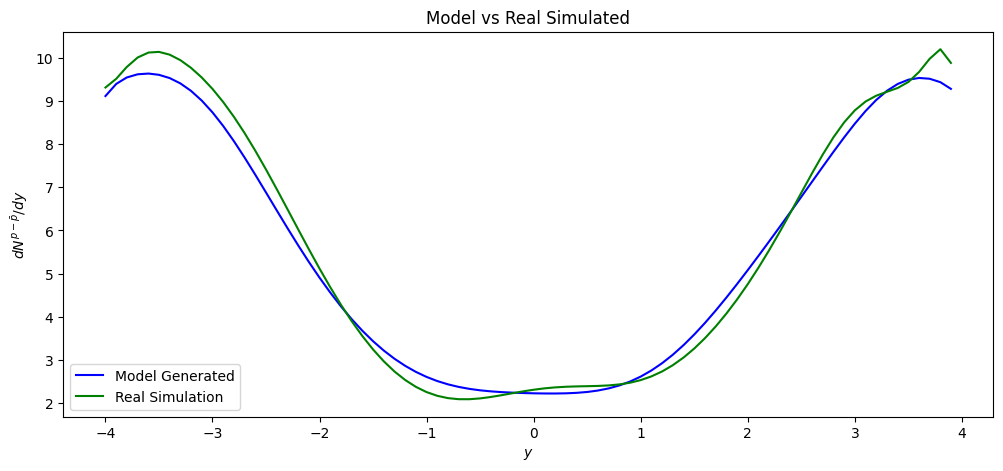

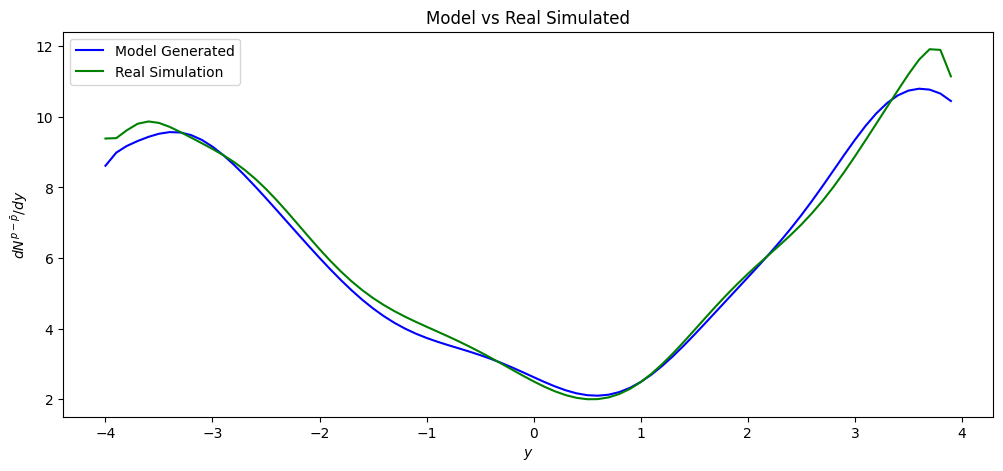

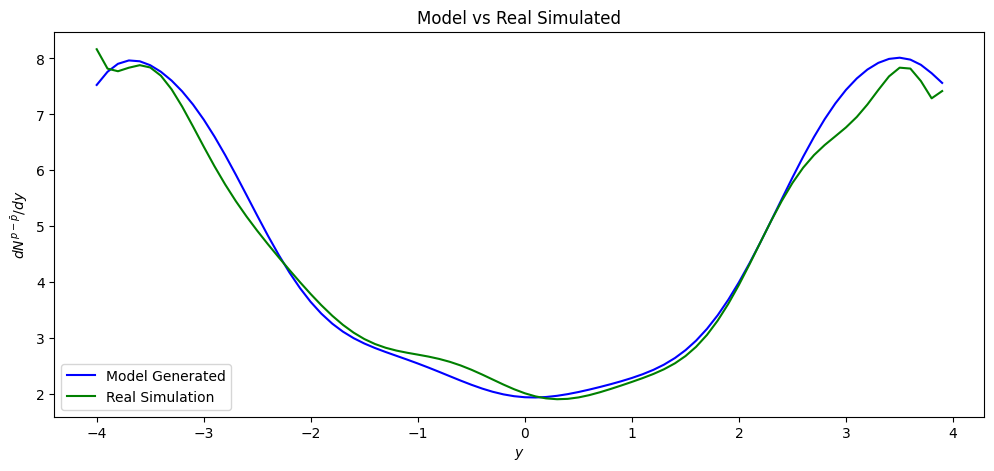

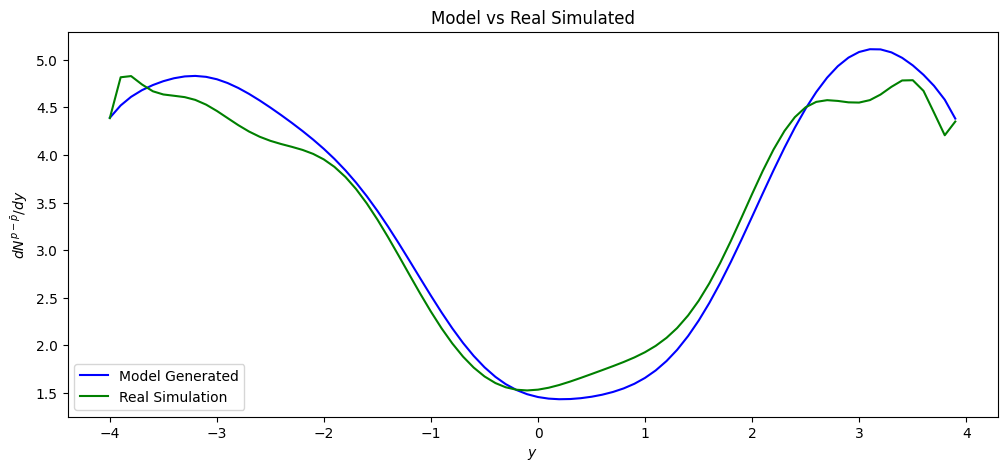

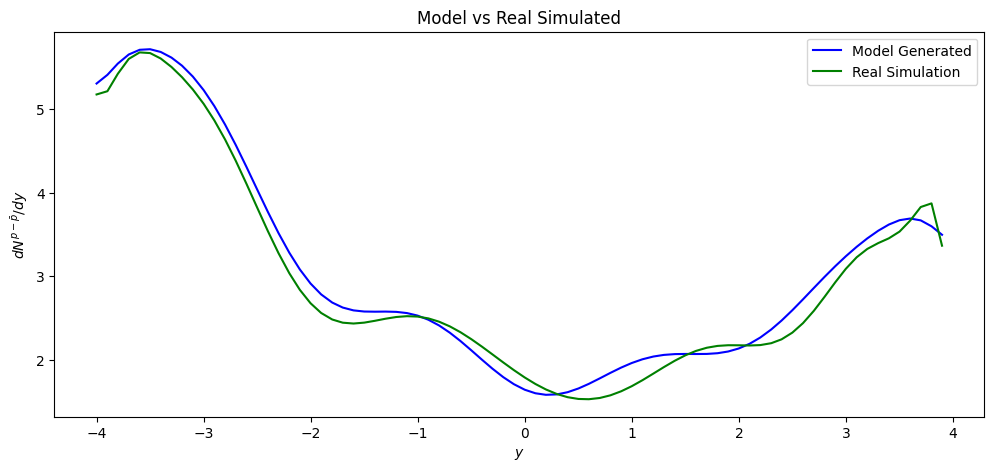

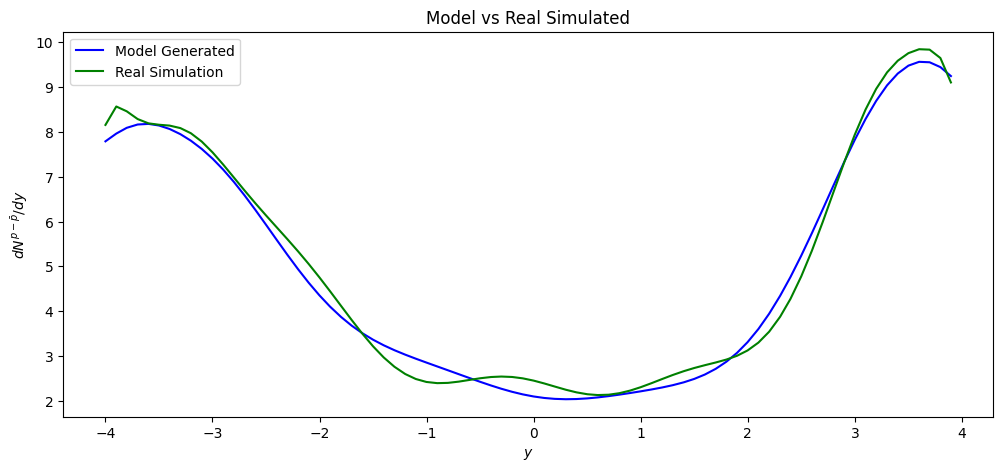

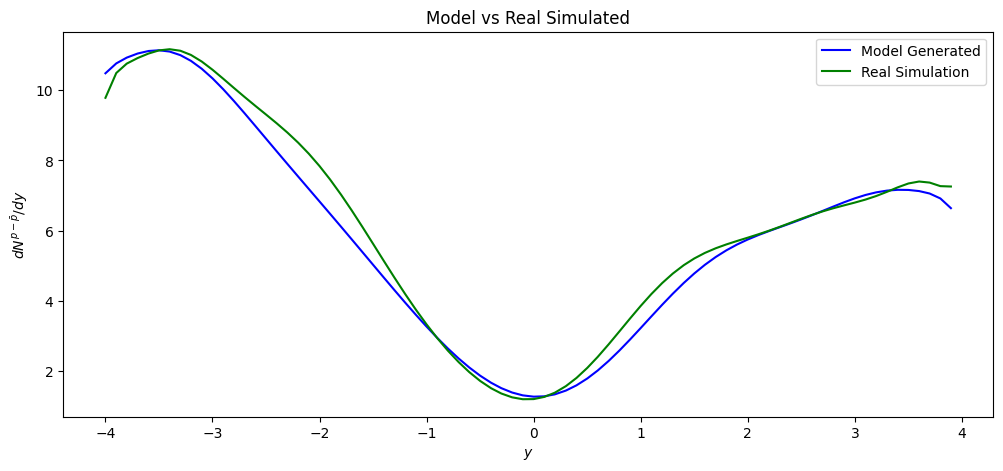

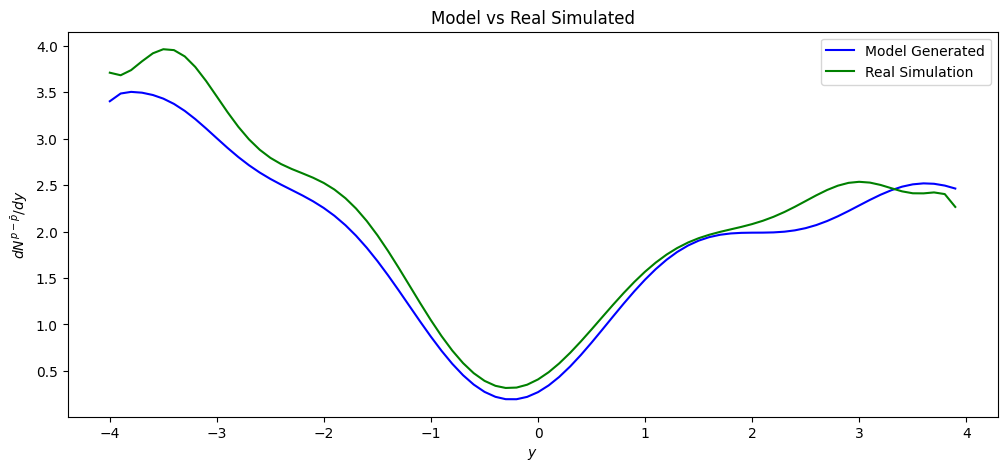

Values for actual final state
Mean: 9.338725090026855
Mean Error: 0.05642343319641575
Standard Diviation: 3.987344741821289
Standard Error: 0.056417786066191807
Variance: 15.898917305318061 
Variance Error: 0.27373050940338095
Skew: 0.5179816148749031
Skew Error: 0.35286458337424637
Kurtosis: 2.4806306354448586
Kurtosis Error: 1.5918791826754746


Values for model output final state
Mean: 9.212968826293945
Mean Error: 0.05558275294875384
Standard Diviation: 3.9279353618621826
Standard Error: 0.05557719015440541
Variance: 15.428676617332444 
Variance Error: 0.2637702180244553
Skew: 0.5117249168697109
Skew Error: 0.34276242536306245
Kurtosis: 2.4599221418780055
Kurtosis Error: 1.5381355044939047


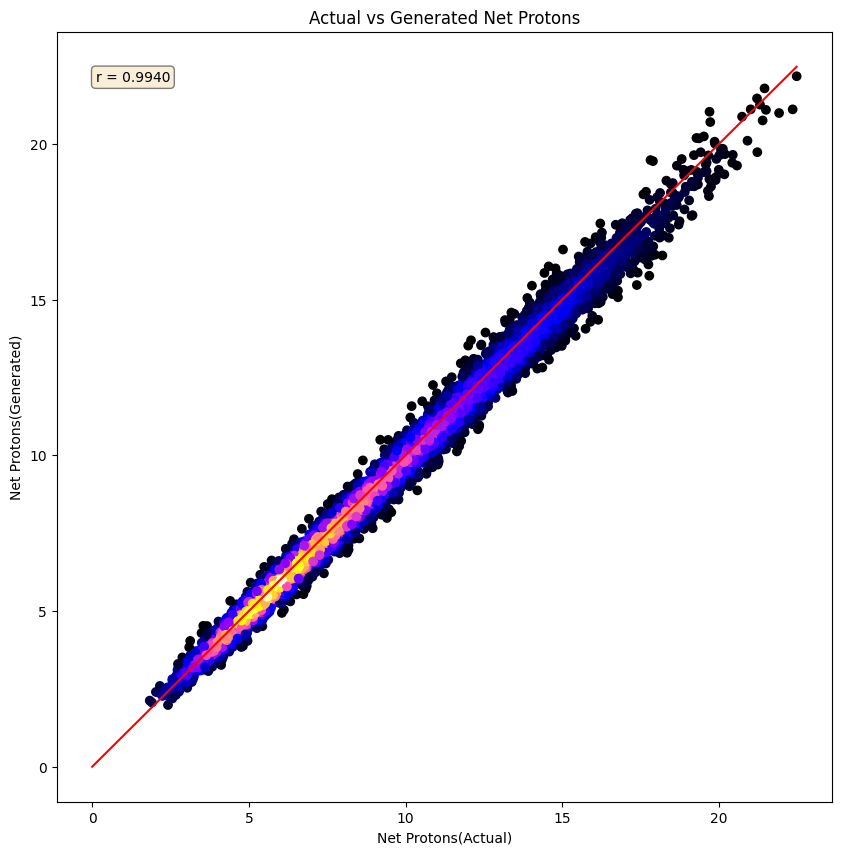

In [4]:
from hydroml.plot import plot_cc_graph, plot_output_compare, plot_output
from hydroml.moments import Moments
from hydroml.utils import trim, poly_regression

finals = []
models = []
bound_1 = -2
bound_2 = 2

import numpy as np

for i, data in enumerate(data_loader):
    key = data[0]
    value = data[1].flatten()

    protons_model = model(key)

    protons_model = protons_model.detach().numpy().flatten()
    protons_model = poly_regression(dataset.etaFinal, protons_model, 15)

    fig = plt.figure(figsize=(12, 5))

    ax = fig.add_subplot()
    ax.plot(dataset.etaFinal, protons_model, label="Model Generated", color='blue')
    ax.plot(dataset.etaFinal, value, label="Real Simulation", color='green')
    ax.set_title("Model vs Real Simulated")
    ax.set_ylabel("$dN^{p-\\bar{p}}/dy$")
    ax.set_xlabel("$y$")
    ax.legend()

    plt.show()

    if i >= 25:
        break

for i, data in enumerate(data_loader):
    key = data[0]
    value = data[1].flatten()

    protons_model = model(key)

    protons_model = protons_model.detach().numpy().flatten()
    protons_model = poly_regression(dataset.etaFinal, protons_model, 15)

    eta_trim, protons_trim = trim( dataset.etaFinal, value, bound_1, bound_2  )
    _, protons_model_trim = trim( dataset.etaFinal, protons_model, bound_1, bound_2  )

    finals.append( np.trapz( protons_trim, x=eta_trim ) )
    models.append( np.trapz( protons_model_trim, x=eta_trim ) )

finals_moments = Moments(finals)
models_moments = Moments(models)

print("Values for actual final state")
print(finals_moments)
print("\n")
print("Values for model output final state")
print(models_moments)

plot_cc_graph(np.array(finals), np.array(models), "Net Protons")